# Importing Necessary libraries

In [1]:
from tensorflow import keras 
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
import matplotlib.image as mpimg
from PIL import Image
import tensorflow.keras.backend as K
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from keras import layers, models, Model
from keras.layers import LSTM, Bidirectional, Dropout, Dense, Embedding
import cv2
import os
from glob import glob
import pandas as pd
from sklearn.model_selection import train_test_split
import math
from google.colab.patches import cv2_imshow
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Visualization of Dataset

Images of Hypertensive Retinopathy class (1)



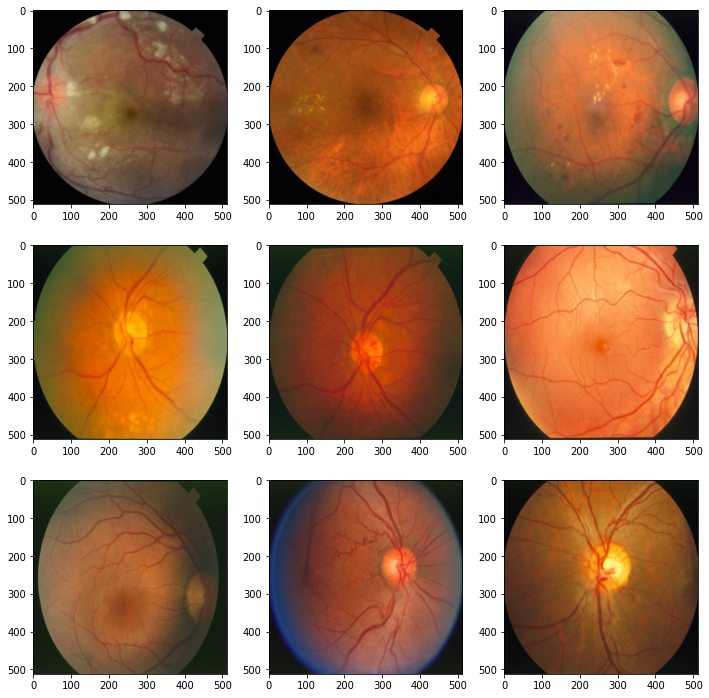

In [3]:
path1 = "/content/drive/MyDrive/Retinal image analysis/Dataset/1/"

print("Images of Hypertensive Retinopathy class (1)\n")
plt.figure(figsize=(10,10))
for i in range(1,10):
   p = i+100 
   img = Image.open(path1 + 'img'+str(p)+'.png')
   plt.subplot(3,3,i)
   plt.tight_layout()
   plt.imshow(img)

Grayscale Images of Hypertensive Retinopathy class (1)



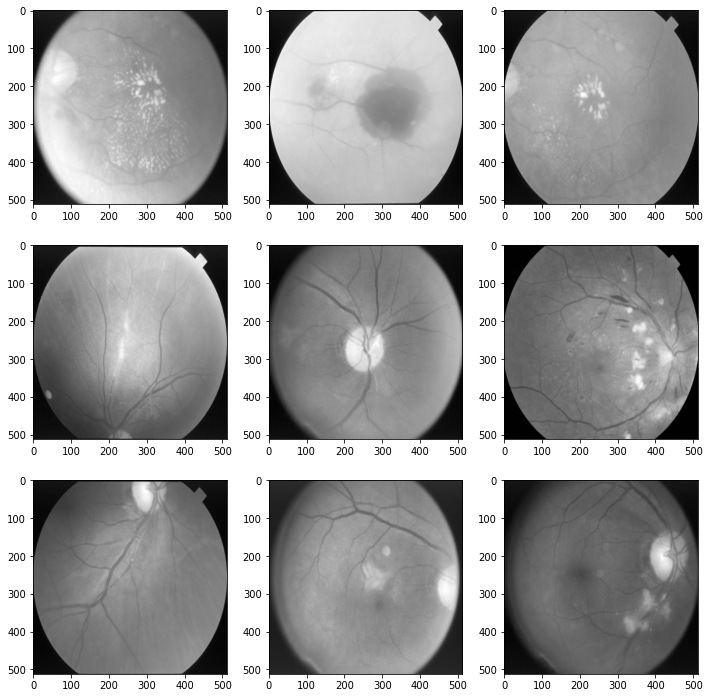

In [4]:
print("Grayscale Images of Hypertensive Retinopathy class (1)\n")
plt.figure(figsize=(10,10))
for i in range(1,10):
   p = i+140 
   img = Image.open(path1 + 'img'+str(p)+'.png')
   gray_img = img.convert("L")
   plt.subplot(3,3,i)
   plt.tight_layout()
   plt.imshow(gray_img,cmap='gray')

Normal Images class (0)



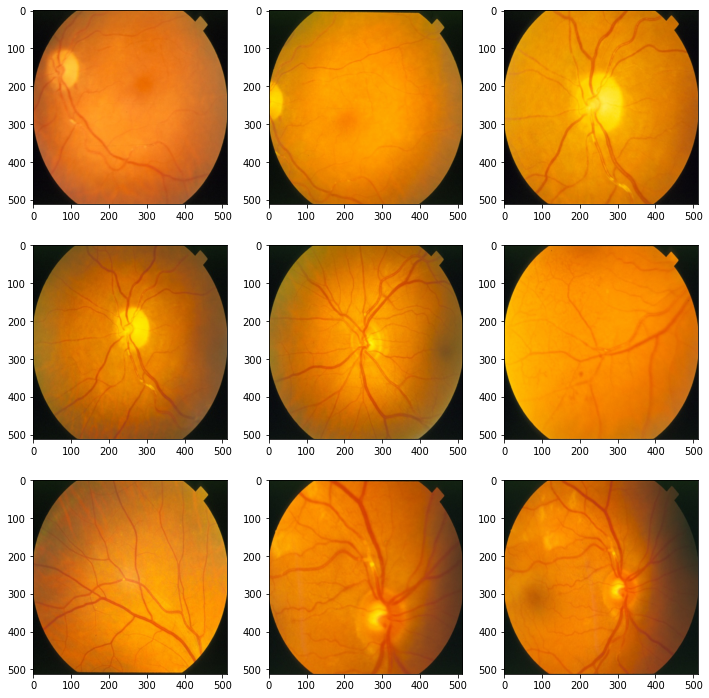

In [5]:
path2 = "/content/drive/MyDrive/Retinal image analysis/Dataset/0/"

print("Normal Images class (0)\n")
plt.figure(figsize=(10,10))
for i in range(1,10):
   p = i+276 
   img = Image.open(path2 + 'img'+str(p)+'.png')
   plt.subplot(3,3,i)
   plt.tight_layout()
   plt.imshow(img)

Grayscale Normal Images class (0)



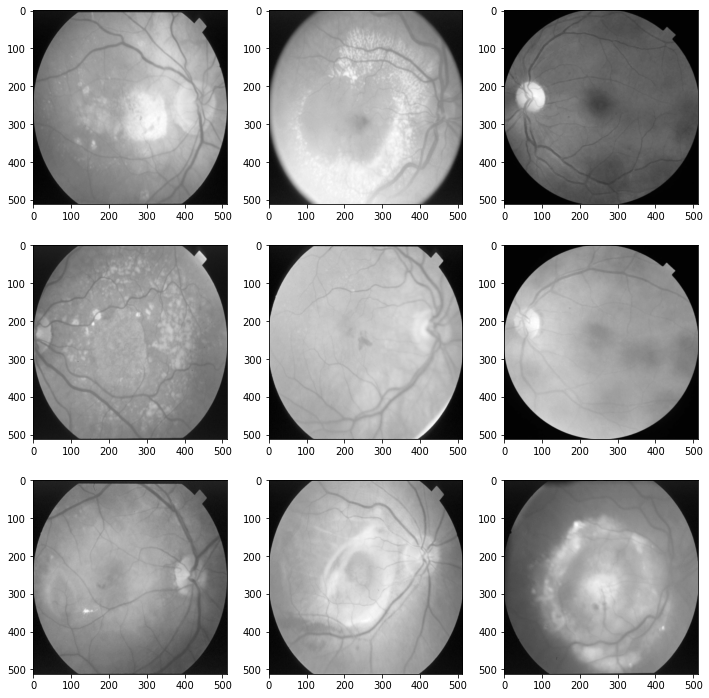

In [6]:
print("Grayscale Normal Images class (0)\n")
plt.figure(figsize=(10,10))
for i in range(1,10):
   p = i+219
   img = Image.open(path1 + 'img'+str(p)+'.png')
   gray_img = img.convert("L")
   plt.subplot(3,3,i)
   plt.tight_layout()
   plt.imshow(gray_img,cmap='gray')

# Data Preprocessing

In [7]:
positive = "/content/drive/MyDrive/Retinal image analysis/Dataset/1"
negative = "/content/drive/MyDrive/Retinal image analysis/Dataset/0"
def get_data(filepath):
    image_data = []
    for img in os.listdir(filepath):
        pic = cv2.imread(os.path.join(filepath,img))
        
        pic = cv2.cvtColor(pic,cv2.COLOR_BGR2GRAY)
        image_data.append(pic)
    image_data = np.array(image_data)
    return image_data
positivesamples = get_data(positive)
negativesamples = get_data(negative)
positivelabels = np.ones(400, dtype = np.int64)
negativelabels = np.zeros(378, dtype = np.int64)

imagedata = np.concatenate([positivesamples, negativesamples])
labels = np.concatenate([positivelabels, negativelabels])

x_train, x_test, y_train, y_test = train_test_split(imagedata, labels,test_size= 0.3, random_state = 2022)

# Utility Functions


In [9]:
def norm(x):
    var = 0
    for i in x:
        var += (i**2)
    return math.sqrt(var)

def cosine(xt, xi):
    normxt = norm(xt)
    normxi = norm(xi)
    cos = np.dot(xi, xt)/(normxi*normxt)
    return cos

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0) 

def attention_model(xt, xi, y):
    ypred = 0
    cos_distances = []
    for i in xi :
        
        c = cosine(xt, i)
        cos_distances.append(c)
    sftmx = softmax(cos_distances)
    for j in range(len(y)):
        ypred += (sftmx[j] * y[j])
    return ypred
def get_predictions(xt, xi, y):
    predictions = []
    for i in xt:
        pred = attention_model(i, xi, y)
        predictions.append(pred)
    bin_pred = []
    for j in predictions:
        if j >= 0.5:
            bin_pred.append(1)
        else :
            bin_pred.append(0)
    return bin_pred

def acc(pred, y):
    correctness = 0
    for i in range(len(y)):
        if pred[i] == y[i]:
            correctness += 1
        else :
            pass
    return (correctness / len(y))
def cnf_mat(pred, y):
    mat = [[0, 0], [0, 0]]
    for i in range(len(y)):
        if(pred[i] == y[i]):
            if y[i] == 1:
                mat[0][0] += 1
            else:
                mat[1][1] += 1
        else:
            if (pred[i] == 1):
                mat[0][1] += 1
            else:
                mat[1][0] += 1
    return (mat)

In [10]:
def plot_confusion(com,title="",category=[0,1],colour="Greens"): 
  group_names = ['True Neg','False Pos','False Neg','True Pos']

  group_counts = ["{0:0.0f}".format(value) for value in com.flatten()]

  group_percentages = ["{0:.2%}".format(value) for value in com.flatten()/np.sum(com)]

  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

  labels = np.asarray(labels).reshape(2,2)
  ax = sns.heatmap(com, annot=labels, fmt='', cmap=colour)
  ax.set_title(title+"\n",size=13,fontweight='bold');
  ax.set_xlabel('\nPredicted class')
  ax.set_ylabel('Actual class ');
  ax.xaxis.set_ticklabels([category[0],category[1]])
  ax.yaxis.set_ticklabels([category[0],category[1]])
  plt.show()

# CNN Models

In [73]:
def get_cnn(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(32,padding = "same" ,activation='relu',input_shape= input_shape, kernel_size=3,strides=2 ))
    model.add(layers.MaxPooling2D(2, 2))

    model.add(layers.Conv2D(64, padding = "same", activation='relu', kernel_size=3, strides=2))
    model.add(layers.MaxPooling2D(2, 2))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation= 'relu'))
    model.add(Dropout(0.3))
    
    model.add(layers.Dense(2, activation = 'softmax'))
    model.build((512, 512))
    model.summary()
    return model

model = get_cnn((512, 512, 1))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 65536)             0         
                                                                 
 dense_5 (Dense)             (None, 128)              

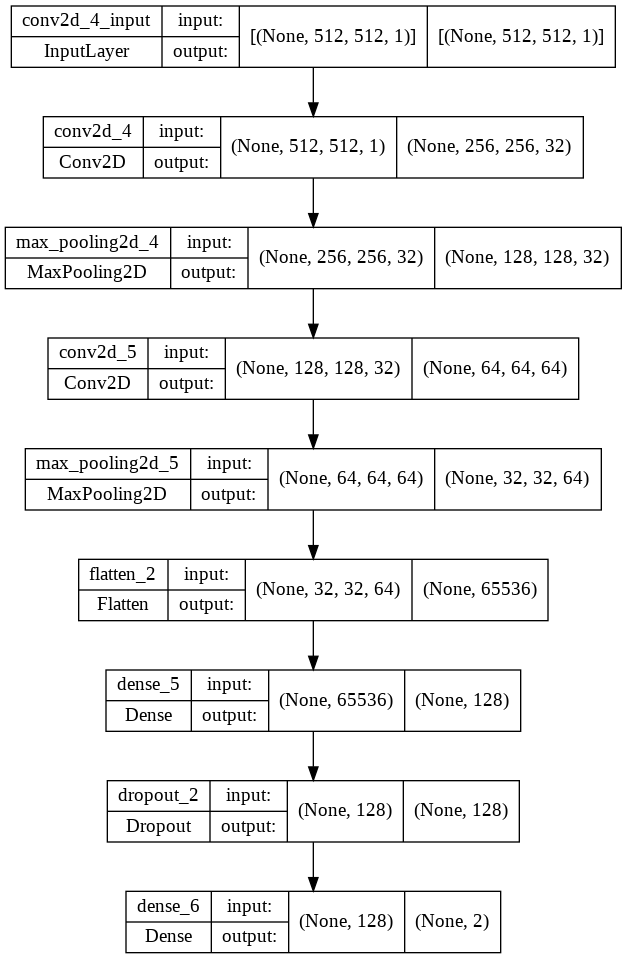

<Figure size 288x432 with 0 Axes>

In [74]:
plt.figure(figsize=(4,6))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

**Training** **CNN**

In [75]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
hist = model.fit(x = x_train, y = y_train, epochs = 50, batch_size=10)

Epoch 1/50
55/55 [==============================] - 1s 17ms/step - loss: 29.2932 - accuracy: 0.6232
Epoch 2/50
55/55 [==============================] - 1s 16ms/step - loss: 0.5549 - accuracy: 0.7169
Epoch 3/50
55/55 [==============================] - 1s 15ms/step - loss: 0.5034 - accuracy: 0.7463
Epoch 4/50
55/55 [==============================] - 1s 16ms/step - loss: 0.4354 - accuracy: 0.7684
Epoch 5/50
55/55 [==============================] - 1s 16ms/step - loss: 0.4018 - accuracy: 0.8107
Epoch 6/50
55/55 [==============================] - 1s 16ms/step - loss: 0.4078 - accuracy: 0.7849
Epoch 7/50
55/55 [==============================] - 1s 16ms/step - loss: 0.3944 - accuracy: 0.8162
Epoch 8/50
55/55 [==============================] - 1s 16ms/step - loss: 0.3420 - accuracy: 0.8309
Epoch 9/50
55/55 [==============================] - 1s 16ms/step - loss: 0.3364 - accuracy: 0.8143
Epoch 10/50
55/55 [==============================] - 1s 15ms/step - loss: 0.3188 - accuracy: 0.8456
Epoch 11

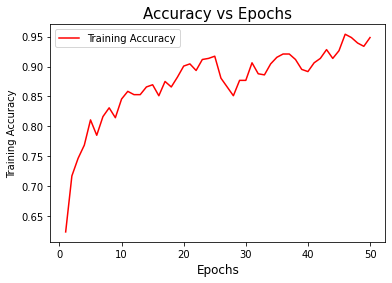

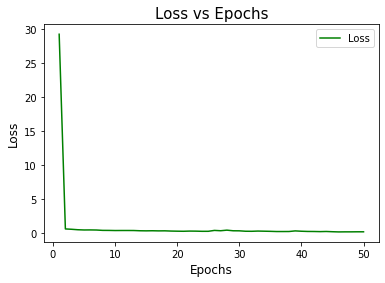

In [76]:
loss = hist.history['loss']
acc = hist.history['accuracy']
epochs = range(1,51)

#accuracy graph
sns.lineplot(epochs , acc,color='red')
plt.title("Accuracy vs Epochs",size=15)
plt.xlabel('Epochs',size=12)
plt.ylabel('Training Accuracy')
plt.legend(['Training Accuracy'])
plt.show()
print("\n")

#loss graph
sns.lineplot(epochs , loss,color="green")
plt.title("Loss vs Epochs",size=15)
plt.xlabel('Epochs',size=12)
plt.ylabel('Loss',size=12)
plt.legend(['Loss'])
plt.show()

Testing On CNN Model only 

In [77]:
pred = model.predict(x_test)
pred = pred.tolist()
predictions = []
for i in pred:
    predictions.append(i.index(max(i)))

Accuracy score for CNN Model only:  80.769 %

Classification Report:

              precision    recall  f1-score   support

           0       0.81      0.80      0.80       115
           1       0.81      0.82      0.81       119

    accuracy                           0.81       234
   macro avg       0.81      0.81      0.81       234
weighted avg       0.81      0.81      0.81       234
 



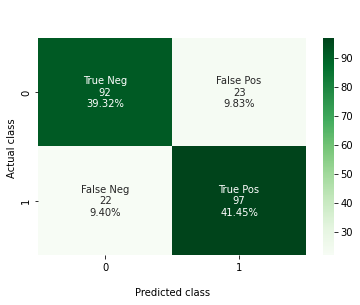

In [78]:
com = confusion_matrix(y_test,predictions)
print("Accuracy score for CNN Model only: ",'{0:.{1}f}'.format(accuracy_score(y_test,predictions) * 100, 3),"%\n")
print("Classification Report:\n")
print(classification_report(y_test,predictions),'\n')
plot_confusion(com)

# LSTM Model

Extracting Flatten Output from CNN model

In [20]:
layer_name = 'flatten'
intermediate_layer_model = Model(inputs=model.input,
                                       outputs=model.get_layer(layer_name).output)
flatten_op1 = intermediate_layer_model(x_train[0: 150])
print(flatten_op1.shape) 
flatten_op2 = intermediate_layer_model(x_train[150:300])
print(flatten_op2.shape)
flatten_op3 = intermediate_layer_model(x_train[300:450])
print(flatten_op3.shape)
flatten_op4 = intermediate_layer_model(x_train[450:544])
print(flatten_op4.shape)

(150, 65536)
(150, 65536)
(150, 65536)
(94, 65536)


In [21]:
flatten_op = tf.concat([flatten_op1, flatten_op2,flatten_op3, flatten_op4 ], 0)
print(flatten_op.shape)

(544, 65536)


LSTM Models(Training and retrieving LSTM Output)

In [22]:
def build_lstm(flatten_op):
    model = models.Sequential()
    model.add((LSTM(128, input_shape = flatten_op)))
    model.add(Dense(1, activation='sigmoid'))
    print(model.summary())
    return model
shape_flatten = (1, 65536)
Lstm = build_lstm(shape_flatten)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               33620480  
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 33,620,609
Trainable params: 33,620,609
Non-trainable params: 0
_________________________________________________________________
None


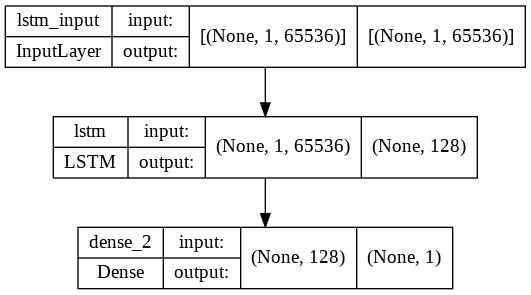

In [23]:
plot_model(Lstm, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [24]:
ytrain = y_train
flatten_op = tf.reshape(flatten_op, (544, 1, 65536))
xtrain = np.array(flatten_op)
print(xtrain.shape)
Lstm.compile(optimizer = "adam", loss = "mse", metrics = ["accuracy"])
hist1 = Lstm.fit(flatten_op, ytrain, epochs = 50, batch_size =5)

(544, 1, 65536)
Epoch 1/50
109/109 [==============================] - 5s 19ms/step - loss: 0.1780 - accuracy: 0.7371
Epoch 2/50
109/109 [==============================] - 2s 19ms/step - loss: 0.1164 - accuracy: 0.8364
Epoch 3/50
109/109 [==============================] - 2s 19ms/step - loss: 0.0848 - accuracy: 0.8732
Epoch 4/50
109/109 [==============================] - 2s 19ms/step - loss: 0.0749 - accuracy: 0.8915
Epoch 5/50
109/109 [==============================] - 2s 19ms/step - loss: 0.0606 - accuracy: 0.9154
Epoch 6/50
109/109 [==============================] - 2s 19ms/step - loss: 0.0502 - accuracy: 0.9246
Epoch 7/50
109/109 [==============================] - 2s 19ms/step - loss: 0.0466 - accuracy: 0.9357
Epoch 8/50
109/109 [==============================] - 2s 19ms/step - loss: 0.0396 - accuracy: 0.9467
Epoch 9/50
109/109 [==============================] - 2s 19ms/step - loss: 0.0360 - accuracy: 0.9522
Epoch 10/50
109/109 [==============================] - 2s 19ms/step - loss:

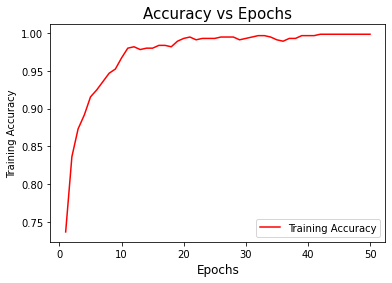

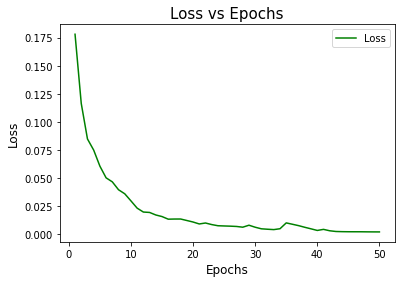

In [25]:
loss = hist1.history['loss']
acc = hist1.history['accuracy']
epochs = range(1,51)

#accuracy graph
sns.lineplot(epochs , acc,color='red')
plt.title("Accuracy vs Epochs",size=15)
plt.xlabel('Epochs',size=12)
plt.ylabel('Training Accuracy')
plt.legend(['Training Accuracy'])
plt.show()
print("\n")

#loss graph
sns.lineplot(epochs , loss,color="green")
plt.title("Loss vs Epochs",size=15)
plt.xlabel('Epochs',size=12)
plt.ylabel('Loss',size=12)
plt.legend(['Loss'])
plt.show()

In [26]:
layer_name = 'lstm'
intermediate_lstm_layer_model = Model(inputs=Lstm.input,
                                       outputs=Lstm.get_layer(layer_name).output)
intermediate_lstm_output_training = intermediate_lstm_layer_model(flatten_op)
print(intermediate_lstm_output_training) 

tf.Tensor(
[[ 7.54724085e-01  2.12270170e-01  4.45407405e-02 ...  1.38093876e-02
   6.20499372e-01  5.93323767e-01]
 [ 1.10343888e-01  4.88088327e-03  8.72731432e-02 ... -2.35414747e-02
   1.04135297e-01 -1.35222882e-01]
 [ 6.53244615e-01  7.43742347e-01  5.50843000e-01 ... -4.23540473e-02
   6.61988080e-01  7.33762860e-01]
 ...
 [-7.57174373e-01 -7.61584222e-01 -7.61591733e-01 ...  7.61593640e-01
  -7.61594176e-01 -7.61594176e-01]
 [ 7.43912160e-01  7.25150287e-01  1.60832144e-02 ...  2.21056267e-04
   7.10781753e-01  7.60606587e-01]
 [ 9.41945761e-02  5.71265630e-02  1.16576545e-01 ... -1.67477518e-01
   1.89012274e-01 -9.42961425e-02]], shape=(544, 128), dtype=float32)


In [27]:
cnn_flatten_test = intermediate_layer_model(x_test)
print(cnn_flatten_test.shape)
cnn_flatten_test = tf.reshape(cnn_flatten_test, (234, 1, 65536))
lstm_test = intermediate_lstm_layer_model(cnn_flatten_test)
print(lstm_test.shape)

(234, 65536)
(234, 128)


Creating Support set for Attention model

(CNN + LSTM)

In [47]:
i = 00
j = 50
supportset_images = []
supportset_labels = []
# print(y_train)
while(i != 10):
    if (y_train[j] == 0):
        supportset_images.append(intermediate_lstm_output_training[j])
        supportset_labels.append(0)
        i+=1
    j+=1
i = 0
j = 50
while(i != 10):
    if (y_train[j] == 1):
        supportset_images.append(intermediate_lstm_output_training[j])
        supportset_labels.append(1)
        i+=1
    j+=1
supportset_images = np.array(supportset_images)
supportset_labels = np.array(supportset_labels)
print(supportset_images.shape)

(20, 128)


Getting predictions from Attention Model

In [48]:
pred = get_predictions(lstm_test, supportset_images, supportset_labels)

Accuracy score for Few Shot Learning Model:  80.342 %

Classification Report:

              precision    recall  f1-score   support

           0       0.81      0.78      0.80       115
           1       0.80      0.82      0.81       119

    accuracy                           0.80       234
   macro avg       0.80      0.80      0.80       234
weighted avg       0.80      0.80      0.80       234
 



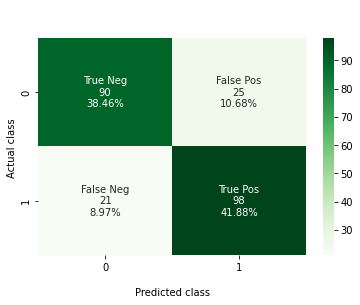

In [65]:
com = confusion_matrix(y_test,pred)
print("Accuracy score for Few Shot Learning Model: ",'{0:.{1}f}'.format(accuracy_score(y_test,pred) * 100, 3),"%\n")
print("Classification Report:\n")
print(classification_report(y_test,pred),'\n')
plot_confusion(com)